In [ ]:
# import packages needed for this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from IPython.display import Javascript
display(Javascript('''
google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})
'''))

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Replace the path the actual folder name
os.chdir('/content/drive/MyDrive/Causal_project_data/Data')

# Confirm that the files are accessible
os.listdir()

Mounted at /content/drive


['Data_GPA_Prior_Post_Actual.csv',
 'Combination_Relative_Ratio.xlsx',
 'Data_Student_Dorm_GPA_Null_Model.csv',
 'Data_Student_Dorm_GPA_Actual.csv',
 'Data_Student_Dorm_GPA_Null_Model.gsheet']

In [ ]:
df_panel = pd.read_csv('Data_GPA_Prior_Post_Actual.csv')
df_student = pd.read_csv('Data_Student_Dorm_GPA_Actual.csv')
df_null = pd.read_csv('Data_Student_Dorm_GPA_Null_Model.csv')

In [ ]:
df_panel_o = df_panel.copy()

In [ ]:
print(f"Panel data : {df_panel.shape}")
print(f"Student-dorm data : {df_student.shape}")
print(f"Null model data: {df_null.shape}")


# Check for duplicates
duplicates = df_panel.duplicated(subset=['No', 'semester']).sum()
print(f"Duplicate student-semester pairs: {duplicates}")
if duplicates == 0:
    print("No duplicates found")

# Check data types
print(df_panel.dtypes)

# Check value ranges
print(f"  gpa_post: [{df_panel['gpa_post'].min():.4f}, {df_panel['gpa_post'].max():.4f}]")
print(f"  gpa_prior: [{df_panel['gpa_prior'].min():.4f}, {df_panel['gpa_prior'].max():.4f}]")
print(f"  rm_avg: [{df_panel['rm_avg'].min():.4f}, {df_panel['rm_avg'].max():.4f}]")
print(f"  rm_diff: [{df_panel['rm_diff'].min():.4f}, {df_panel['rm_diff'].max():.4f}]")


# Check categorical variables
print(f"Gender: {sorted(df_panel['gender'].unique())} (0=Male, 1=Female)")
print(f"Cohort: {sorted(df_panel['cohort'].unique())} (admission years)")
print(f"Semester: {sorted(df_panel['semester'].unique())} (semester transitions)")
print(f"Major: {df_panel['major'].nunique()} unique majors")

# Sample distribution
print(f"\nTotal observations: {len(df_panel):,}")
print(f"Unique students: {df_panel['No'].nunique():,}")
print(f"Average observations per student: {len(df_panel)/df_panel['No'].nunique():.2f}")
print(f"Unique semesters: {df_panel['semester'].nunique():,}")
# print(df_panel['semester'].value_counts().sort_index())

print(df_panel.groupby('cohort')['No'].nunique())
# print(df_panel.groupby('major')['No'].nunique())
gender_dist = df_panel.groupby('gender')['No'].nunique()
print(gender_dist)
print(f"  Male: {gender_dist[0]/gender_dist.sum()*100:.1f}%")
print(f"  Female: {gender_dist[1]/gender_dist.sum()*100:.1f}%")

Panel data : (15680, 10)
Student-dorm data : (8, 10)
Null model data: (8, 11)
Duplicate student-semester pairs: 0
No duplicates found
No             int64
gpa_post     float64
gpa_prior    float64
rm_avg       float64
rm_diff      float64
or_indorm      int64
gender         int64
major          int64
cohort         int64
semester       int64
dtype: object
  gpa_post: [0.0000, 1.0000]
  gpa_prior: [0.0000, 1.0000]
  rm_avg: [0.0179, 0.9890]
  rm_diff: [0.0043, 0.6667]
Gender: [np.int64(0), np.int64(1)] (0=Male, 1=Female)
Cohort: [np.int64(1), np.int64(2)] (admission years)
Semester: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)] (semester transitions)
Major: 36 unique majors

Total observations: 15,680
Unique students: 5,272
Average observations per student: 2.97
Unique semesters: 4
cohort
1    2568
2    2704
Name: No, dtype: int64
gender
0    4068
1    1204
Name: No, dtype: int64
  Male: 77.2%
  Female: 22.8%


# EDA

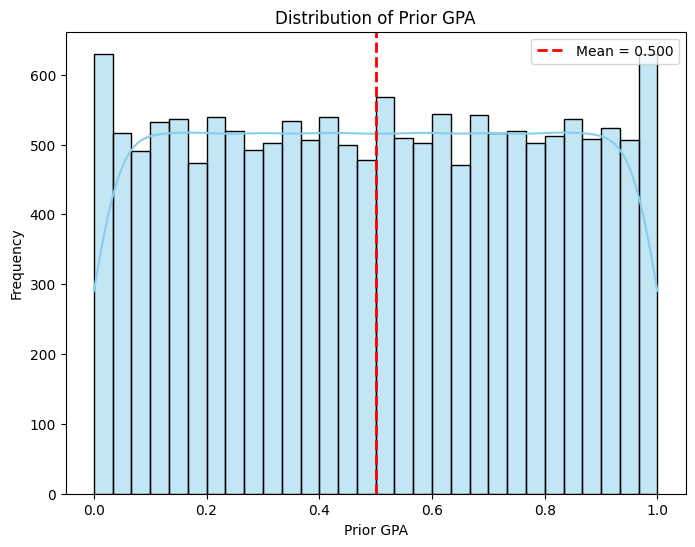

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_panel['gpa_prior'], bins=30, kde=True, color='skyblue')
plt.axvline(df_panel['gpa_prior'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_panel["gpa_prior"].mean():.3f}')
plt.title('Distribution of Prior GPA')
plt.xlabel('Prior GPA')
plt.ylabel('Frequency')
plt.legend()
plt.show()

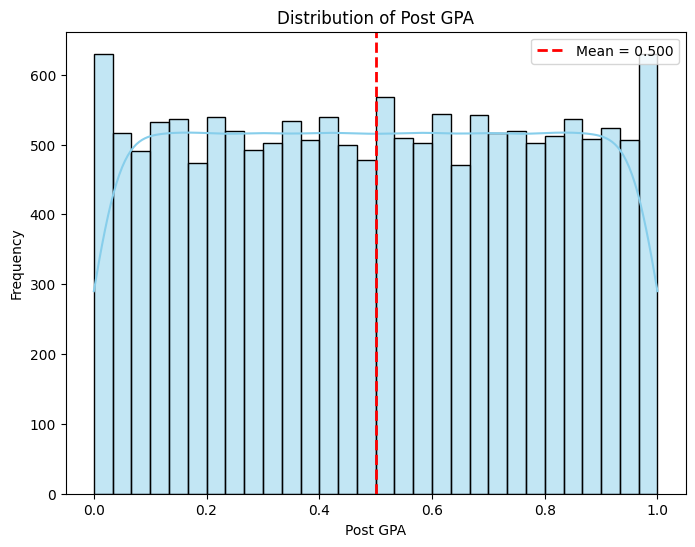

In [ ]:
#Post GPA histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_panel['gpa_post'], bins=30, kde=True, color='skyblue')
plt.axvline(df_panel['gpa_post'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_panel["gpa_post"].mean():.3f}')
plt.title('Distribution of Post GPA')
plt.xlabel('Post GPA')
plt.ylabel('Frequency')
plt.legend()
plt.show()

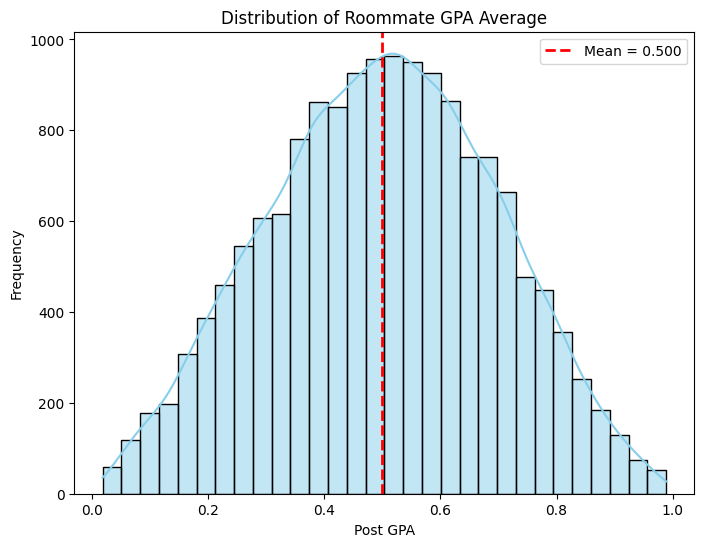

In [ ]:
#Post GPA histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_panel['rm_avg'], bins=30, kde=True, color='skyblue')
plt.axvline(df_panel['rm_avg'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_panel["rm_avg"].mean():.3f}')
plt.title('Distribution of Roommate GPA Average')
plt.xlabel('Post GPA')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:

# Pick variables you want in the paper
vars_main = ['gpa_post','gpa_prior','rm_avg','rm_diff','or_indorm','gender']

# Overall summary stats (clean, paper-friendly)
summary_overall = (df_panel[vars_main]
                   .agg(['count','mean','std','min','median','max'])
                   .T
                   .rename(columns={
                       'count':'N', 'mean':'Mean', 'std':'SD',
                       'min':'Min', 'median':'Median', 'max':'Max'
                   }))

# Add 25th/75th percentiles (optional but nice)
q = df_panel[vars_main].quantile([0.25, 0.75]).T
q.columns = ['P25','P75']
summary_overall = summary_overall.join(q)

# Round for display
summary_overall = summary_overall[['N','Mean','SD','Min','P25','Median','P75','Max']].round(3)

summary_overall


,N,Mean,SD,Min,P25,Median,P75,Max
gpa_post,15680.0,0.500,0.292,0.000,0.248,0.500,0.752,1.000
gpa_prior,15680.0,0.500,0.292,0.000,0.248,0.500,0.752,1.000
rm_avg,15680.0,0.500,0.195,0.018,0.361,0.503,0.641,0.989
rm_diff,15680.0,0.303,0.150,0.004,0.183,0.293,0.414,0.667
or_indorm,15680.0,2.500,1.118,1.000,1.000,2.500,3.000,4.000
gender,15680.0,0.226,0.418,0.000,0.000,0.000,0.000,1.000


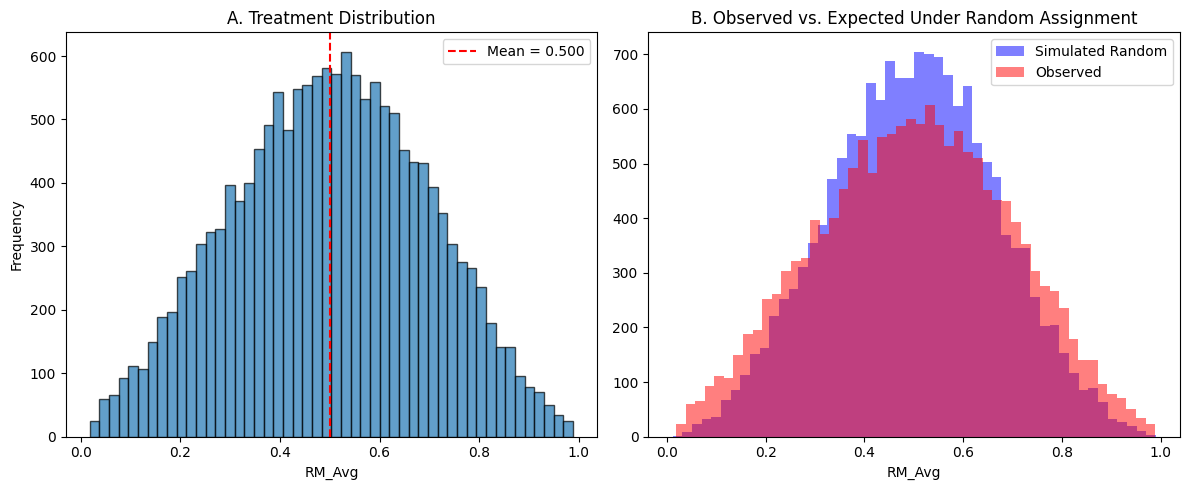

In [ ]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: RM_Avg distribution
axes[0].hist(df_panel['rm_avg'], bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(df_panel['rm_avg'].mean(), color='red', linestyle='--',
                label=f'Mean = {df_panel["rm_avg"].mean():.3f}')
axes[0].set_xlabel('RM_Avg')
axes[0].set_ylabel('Frequency')
axes[0].set_title('A. Treatment Distribution')
axes[0].legend()

# Panel B: Overlay with simulated random assignment
np.random.seed(42)
simulated = np.random.choice(df_panel['gpa_prior'], size=(len(df_panel), 3)).mean(axis=1)
axes[1].hist(simulated, bins=50, alpha=0.5, label='Simulated Random', color='blue')
axes[1].hist(df_panel['rm_avg'], bins=50, alpha=0.5, label='Observed', color='red')
axes[1].set_xlabel('RM_Avg')
axes[1].set_title('B. Observed vs. Expected Under Random Assignment')
axes[1].legend()

plt.tight_layout()
plt.savefig('treatment_distribution_validation.png', dpi=300)

# Covariate Balance Check

### Gender Balance

In [ ]:
import numpy as np
import pandas as pd

def smd_two_groups(df, group_col, var, g0, g1):
    """
    Compute mean difference and standardized mean difference (SMD)
    between two groups g0 and g1 for variable var.
    """
    x0 = df.loc[df[group_col] == g0, var].dropna()
    x1 = df.loc[df[group_col] == g1, var].dropna()

    m0, m1 = x0.mean(), x1.mean()
    s0, s1 = x0.std(ddof=1), x1.std(ddof=1)

    pooled_sd = np.sqrt((s0**2 + s1**2) / 2)
    smd = (m1 - m0) / pooled_sd if pooled_sd > 0 else np.nan

    return m0, m1, (m1 - m0), smd


In [ ]:
def balance_table_two_groups(df, group_col, vars_list, g0, g1, pretty_names=None):
    """
    Create balance table with mean differences and SMDs
    comparing group g0 vs g1.
    """
    rows = []

    for v in vars_list:
        m0, m1, diff, smd = smd_two_groups(df, group_col, v, g0, g1)
        rows.append({
            'Variable': pretty_names.get(v, v) if pretty_names else v,
            f'Mean {group_col}={g0}': m0,
            f'Mean {group_col}={g1}': m1,
            'Mean Diff (g1-g0)': diff,
            'SMD': smd
        })

    return pd.DataFrame(rows)


In [ ]:
g0 = 1   # cohort 1
g1 = 2   # cohort 2


In [ ]:
balance_vars = ['gpa_prior', 'gender']

pretty_names = {
    'gpa_prior': 'Own GPA percentile (t-1)',
    'gender': 'Gender (1=Female)'
}


In [ ]:
balance_cohort = balance_table_two_groups(
    df=df_panel,
    group_col='cohort',
    vars_list=balance_vars,
    g0=g0,
    g1=g1,
    pretty_names=pretty_names
).round(3)

balance_cohort


,Variable,Mean cohort=1,Mean cohort=2,Mean Diff (g1-g0),SMD
0,Own GPA percentile (t-1),0.50,0.500,0.000,0.000
1,Gender (1=Female),0.22,0.237,0.017,0.041


In [ ]:
# =========================
# COVARIATE BALANCE CHECKS
# Main dataset: df_panel
# Covariates requested: gender, major (36), cohort, semester (4)
# Key note: semester index is cohort-specific, so we DO NOT test "semester balance across cohorts"
# =========================

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

# -------------------------
# 0) Quick sanity checks
# -------------------------
required_cols = ['gender', 'major', 'cohort', 'semester', 'gpa_prior', 'rm_avg']
missing = [c for c in required_cols if c not in df_panel.columns]
if missing:
    raise ValueError(f"Missing columns in df_panel: {missing}")

# -------------------------
# 1) Helper functions
# -------------------------
def smd_two_groups(df, group_col, var, g0, g1):
    """Mean difference + standardized mean difference (SMD) between groups g0 and g1."""
    x0 = df.loc[df[group_col] == g0, var].dropna()
    x1 = df.loc[df[group_col] == g1, var].dropna()

    m0, m1 = x0.mean(), x1.mean()
    s0, s1 = x0.std(ddof=1), x1.std(ddof=1)
    pooled_sd = np.sqrt((s0**2 + s1**2) / 2)

    smd = (m1 - m0) / pooled_sd if pooled_sd > 0 else np.nan
    return m0, m1, (m1 - m0), smd


def balance_table_two_groups(df, group_col, vars_list, g0, g1, labels=None):
    """Balance table with mean diff + SMD for numeric/binary covariates."""
    rows = []
    for v in vars_list:
        m0, m1, diff, smd = smd_two_groups(df, group_col, v, g0, g1)
        rows.append({
            'Variable': labels.get(v, v) if labels else v,
            f'Mean {group_col}={g0}': m0,
            f'Mean {group_col}={g1}': m1,
            'Mean Diff (g1-g0)': diff,
            'SMD': smd
        })
    return pd.DataFrame(rows)


def smd_flag(x):
    if pd.isna(x):
        return ""
    ax = abs(x)
    if ax < 0.1:
        return "OK (<0.1)"
    elif ax < 0.2:
        return "Moderate (0.1–0.2)"
    else:
        return "Imbalance (>0.2)"


# -------------------------
# 2) Balance across COHORTS (binary) for numeric/binary covariates:
#    - gender
#    - gpa_prior
# -------------------------
labels = {
    'gender': 'Gender (1=Female)',
    'gpa_prior': 'Own GPA percentile (t−1)'
}

balance_numeric_by_cohort = balance_table_two_groups(
    df=df_panel,
    group_col='cohort',
    vars_list=['gender', 'gpa_prior'],
    g0=1,
    g1=2,
    labels=labels
).round(3)

balance_numeric_by_cohort['SMD Flag'] = balance_numeric_by_cohort['SMD'].apply(smd_flag)

print("\n=== Balance across cohorts (Mean differences + SMD) ===")
display(balance_numeric_by_cohort)


# -------------------------
# 3) Balance across COHORTS for categorical covariates:
#    - major (36 categories): distribution + chi-square test
#    (SMD is not appropriate for many-category variables.)
# -------------------------
print("\n=== Major balance across cohorts (Chi-square test) ===")

major_ct = pd.crosstab(df_panel['major'], df_panel['cohort'])
chi2_major, p_major, _, _ = chi2_contingency(major_ct)

print(f"Chi-square statistic (major x cohort): {chi2_major:.3f}")
print(f"p-value: {p_major:.6f}")

# Optional diagnostic: show majors with largest cohort composition differences (top 10)
major_dist = pd.crosstab(df_panel['major'], df_panel['cohort'], normalize='columns')
major_dist['abs_diff'] = (major_dist[1] - major_dist[2]).abs()
major_dist_sorted = major_dist.sort_values('abs_diff', ascending=False)

print("\nTop 10 majors by absolute difference in cohort shares (diagnostic):")
display(major_dist_sorted.head(10).round(4))


# -------------------------
# 4) SEMESTER note + within-cohort descriptives (recommended)
#    Semester index is cohort-specific (Semester 1 differs across cohorts in calendar time),
#    so DO NOT interpret semester x cohort as a balance test.
#    Instead, show within-cohort descriptives (appendix-quality).
# -------------------------
print("\n=== Semester handling (IMPORTANT NOTE) ===")
print("Semester is a time index and cohort-specific; do NOT treat semester balance across cohorts as a randomization check.")
print("Instead, we report within-cohort descriptives of pre-treatment covariates by semester (optional/appendix).")

within_cohort_semester_desc = (
    df_panel
    .groupby(['cohort', 'semester'])
    .agg(
        N=('gpa_prior', 'size'),
        gpa_prior_mean=('gpa_prior', 'mean'),
        gpa_prior_sd=('gpa_prior', 'std'),
        female_share=('gender', 'mean')
    )
    .round(3)
)

print("\nWithin-cohort descriptives by semester (cohort × semester):")
display(within_cohort_semester_desc)


# -------------------------
# 5) Joint regression-style balance check (treatment predictability)
#    Does rm_avg depend on observables? (Low R^2 supports as-if random assignment conditional on FE.)
# -------------------------
print("\n=== Joint balance regression: rm_avg ~ covariates + FE ===")

# This is a strong, compact check you can cite in the paper:
# - includes cohort FE, semester FE, and major FE
# - includes gender and gpa_prior as pre-treatment covariates
balance_reg = smf.ols(
    "rm_avg ~ gpa_prior + gender + C(cohort) + C(semester) + C(major)",
    data=df_panel
).fit(cov_type='HC1')

print(f"R-squared: {balance_reg.rsquared:.4f}")
print(balance_reg.summary().tables[1])  # coefficients table only (cleaner than full summary)



=== Balance across cohorts (Mean differences + SMD) ===


,Variable,Mean cohort=1,Mean cohort=2,Mean Diff (g1-g0),SMD,SMD Flag
0,Gender (1=Female),0.22,0.237,0.017,0.041,OK (<0.1)
1,Own GPA percentile (t−1),0.50,0.500,0.000,0.000,OK (<0.1)



=== Major balance across cohorts (Chi-square test) ===
Chi-square statistic (major x cohort): 2797.043
p-value: 0.000000

Top 10 majors by absolute difference in cohort shares (diagnostic):


cohort,1,2,abs_diff
major,,,
11,0.0744,0.0000,0.0744
7,0.0798,0.0137,0.0661
14,0.0611,0.0000,0.0611
8,0.0709,0.0152,0.0557
6,0.0358,0.0810,0.0452
5,0.0413,0.0788,0.0375
18,0.0027,0.0381,0.0354
4,0.0444,0.0795,0.0351
3,0.0549,0.0851,0.0302



=== Semester handling (IMPORTANT NOTE) ===
Semester is a time index and cohort-specific; do NOT treat semester balance across cohorts as a randomization check.
Instead, we report within-cohort descriptives of pre-treatment covariates by semester (optional/appendix).

Within-cohort descriptives by semester (cohort × semester):


N  gpa_prior_mean  gpa_prior_sd  female_share
cohort semester                                                  
1      1         2568             0.5         0.293         0.220
       2         2568             0.5         0.293         0.220
       3         2568             0.5         0.293         0.220
       4         2568             0.5         0.293         0.220
2      1         2704             0.5         0.292         0.237
       2         2704             0.5         0.292         0.237


=== Joint balance regression: rm_avg ~ covariates + FE ===
R-squared: 0.0886
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4072      0.006     64.711      0.000       0.395       0.420
C(cohort)[T.2]       0.0019      0.004      0.478      0.633      -0.006       0.009
C(semester)[T.2]  1.631e-15      0.004   4.51e-13      1.000      -0.007       0.007
C(semester)[T.3]  8.916e-16      0.005   1.83e-13      1.000      -0.010       0.010
C(semester)[T.4]  3.456e-15      0.005   7.09e-13      1.000      -0.010       0.010
C(major)[T.2]        0.0022      0.007      0.296      0.768      -0.012       0.017
C(major)[T.3]        0.0122      0.008      1.630      0.103      -0.002       0.027
C(major)[T.4]       -0.0095      0.008     -1.183      0.237      -0.025       0.006
C(major)[T.5]       -0.0069      0.008     -0.849      0.396      -0.023

In [ ]:
# ==========================================
# SELECTION / RANDOM ASSIGNMENT VALIDATION
# Goal: test whether pre-treatment covariates predict treatment (rm_avg)
# Tests requested:
#   1) Does GPA_Prior predict RM_Avg?
#   2) Do gender / major predict RM_Avg?
# Interpretation: if observables explain little of rm_avg (low R^2; weak joint tests),
# it supports "as-if random assignment" conditional on the assignment process.
# ==========================================

import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# --- (A) Minimal test: does GPA_Prior predict RM_Avg? ---
m1 = smf.ols("rm_avg ~ gpa_prior", data=df_panel).fit(cov_type="HC1")
print("\n(A) rm_avg ~ gpa_prior")
print(f"R^2: {m1.rsquared:.4f}")
print(m1.summary().tables[1])  # coefficient table

# --- (B) Add gender: does gender predict RM_Avg (beyond GPA_Prior)? ---
m2 = smf.ols("rm_avg ~ gpa_prior + gender", data=df_panel).fit(cov_type="HC1")
print("\n(B) rm_avg ~ gpa_prior + gender")
print(f"R^2: {m2.rsquared:.4f}")
print(m2.summary().tables[1])

# --- (C) Add major FE: does major predict RM_Avg (beyond GPA_Prior + gender)? ---
# With many majors (36), use fixed effects via C(major)
m3 = smf.ols("rm_avg ~ gpa_prior + gender + C(major)", data=df_panel).fit(cov_type="HC1")
print("\n(C) rm_avg ~ gpa_prior + gender + major FE")
print(f"R^2: {m3.rsquared:.4f}")
# show a compact summary instead of all dummy coefficients
print(m3.summary().tables[0])  # model info table (R^2, N)
print("Note: major FE includes many indicators; coefficient table omitted for readability.")

# --- (D) Add cohort + semester FE: strongest “selection” diagnostic (recommended) ---
m4 = smf.ols("rm_avg ~ gpa_prior + gender + C(major) + C(cohort) + C(semester)",
             data=df_panel).fit(cov_type="HC1")
print("\n(D) rm_avg ~ gpa_prior + gender + major FE + cohort FE + semester FE")
print(f"R^2: {m4.rsquared:.4f}")
print("Note: FE model includes many indicators; coefficient table omitted for readability.")

# --- (E) Joint significance tests (do gender/major jointly predict rm_avg?) ---
# Use classical F-tests (ANOVA). This uses non-robust covariance for the F-test,
# but it's standard as a diagnostic. (You can still report robust SE in regression tables.)
m3_nr = smf.ols("rm_avg ~ gpa_prior + gender + C(major)", data=df_panel).fit()
m1_nr = smf.ols("rm_avg ~ gpa_prior", data=df_panel).fit()
m2_nr = smf.ols("rm_avg ~ gpa_prior + gender", data=df_panel).fit()

# Test whether adding gender improves fit beyond GPA_Prior
anova_gender = anova_lm(m1_nr, m2_nr)
print("\n(E1) Joint test: Does adding gender improve prediction of rm_avg beyond GPA_Prior?")
print(anova_gender)

# Test whether adding major FE improves fit beyond GPA_Prior + gender
anova_major = anova_lm(m2_nr, m3_nr)
print("\n(E2) Joint test: Do major fixed effects improve prediction of rm_avg beyond GPA_Prior + gender?")
print(anova_major)

# --- (F) Optional: concise “report table” for notebook writeup ---
report = pd.DataFrame({
    "Model": [
        "rm_avg ~ gpa_prior",
        "rm_avg ~ gpa_prior + gender",
        "rm_avg ~ gpa_prior + gender + major FE",
        "rm_avg ~ gpa_prior + gender + major FE + cohort FE + semester FE"
    ],
    "R2": [m1.rsquared, m2.rsquared, m3.rsquared, m4.rsquared],
    "N": [int(m1.nobs), int(m2.nobs), int(m3.nobs), int(m4.nobs)]
}).round(4)

print("\nModel comparison summary:")
display(report)

# --- (G) Interpretation template (markdown you can paste in a cell) ---
print("\nINTERPRETATION GUIDANCE:")
print("""
- If gpa_prior has a positive coefficient, that can be mechanically expected because rm_avg is constructed from peers' prior GPA percentiles
  within the same academic structure. This does not necessarily imply sorting, especially if assignment is within strata (e.g., major/cohort/gender).
- The key diagnostics are:
    (i) whether gender and major substantially improve prediction of rm_avg, and
    (ii) whether the overall R^2 remains low after including covariates and FE.
- Low R^2 and weak incremental fit from gender/major (especially after adding FE) support 'as-if random assignment' conditional on controls.
""")



(A) rm_avg ~ gpa_prior
R^2: 0.0631
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4162      0.003    135.685      0.000       0.410       0.422
gpa_prior      0.1676      0.005     32.015      0.000       0.157       0.178

(B) rm_avg ~ gpa_prior + gender
R^2: 0.0814
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4067      0.003    132.172      0.000       0.401       0.413
gpa_prior      0.1579      0.005     30.096      0.000       0.148       0.168
gender         0.0635      0.003     18.189      0.000       0.057       0.070

(C) rm_avg ~ gpa_prior + gender + major FE
R^2: 0.0886
                            OLS Regression Results                            
Dep. Variable:                 rm_avg   R-squared:                       

,Model,R2,N
0,rm_avg ~ gpa_prior,0.0631,15680
1,rm_avg ~ gpa_prior + gender,0.0814,15680
2,rm_avg ~ gpa_prior + gender + major FE,0.0886,15680
3,rm_avg ~ gpa_prior + gender + major FE + cohor...,0.0886,15680



INTERPRETATION GUIDANCE:

- If gpa_prior has a positive coefficient, that can be mechanically expected because rm_avg is constructed from peers' prior GPA percentiles
  within the same academic structure. This does not necessarily imply sorting, especially if assignment is within strata (e.g., major/cohort/gender).
- The key diagnostics are:
    (i) whether gender and major substantially improve prediction of rm_avg, and
    (ii) whether the overall R^2 remains low after including covariates and FE.
- Low R^2 and weak incremental fit from gender/major (especially after adding FE) support 'as-if random assignment' conditional on controls.



# Estimate Direct Effect

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
print("\nMean-centering variables...")
continuous_vars = ['gpa_post', 'gpa_prior', 'rm_avg', 'rm_diff', 'or_indorm']

for var in continuous_vars:
    mean_val = df_panel[var].mean()
    df_panel[f'{var}_c'] = df_panel[var] - mean_val

print("✓ Variables mean-centered")



Mean-centering variables...
✓ Variables mean-centered


In [ ]:
import statsmodels.formula.api as smf

print("\n" + "="*80)
print("DIRECT EFFECT OF ROOMMATE ACADEMIC ABILITY (RM_Avg)")
print("="*80)

print("\nResearch Question:")
print("Does roommates’ prior academic ability causally affect student GPA?")

print("\nH1: β(RM_Avg) > 0 (positive peer spillover)")



DIRECT EFFECT OF ROOMMATE ACADEMIC ABILITY (RM_Avg)

Research Question:
Does roommates’ prior academic ability causally affect student GPA?

H1: β(RM_Avg) > 0 (positive peer spillover)


In [ ]:
print("\n" + "-"*80)
print("MODEL 1a: Bivariate Regression (No Controls)")
print("-"*80)

model_1a = smf.ols(
    "gpa_post ~ rm_avg",
    data=df_panel
).fit(cov_type="HC3")

print(f"RM_Avg coefficient: {model_1a.params['rm_avg']:.4f}")
print(f"Std. Error:         {model_1a.bse['rm_avg']:.4f}")
print(f"p-value:            {model_1a.pvalues['rm_avg']:.4f}")
print(f"R²:                 {model_1a.rsquared:.4f}")
print(f"N:                  {int(model_1a.nobs):,}")

delta_10pp = model_1a.params['rm_avg'] * 0.10
print("\nInterpretation:")
print(f"A 10-percentile-point increase in roommate GPA")
print(f"is associated with a {delta_10pp*100:.2f} percentile-point")
print(f"increase in own GPA.")



--------------------------------------------------------------------------------
MODEL 1a: Bivariate Regression (No Controls)
--------------------------------------------------------------------------------
RM_Avg coefficient: 0.3650
Std. Error:         0.0114
p-value:            0.0000
R²:                 0.0593
N:                  15,680

Interpretation:
A 10-percentile-point increase in roommate GPA
is associated with a 3.65 percentile-point
increase in own GPA.


In [ ]:
print("\n" + "-"*80)
print("MODEL 1b: Add Prior GPA Control")
print("-"*80)

model_1b = smf.ols(
    "gpa_post ~ gpa_prior + rm_avg",
    data=df_panel
).fit(cov_type="HC3")

print(f"GPA_Prior coefficient: {model_1b.params['gpa_prior']:.4f}")
print(f"RM_Avg coefficient:    {model_1b.params['rm_avg']:.4f}")
print(f"RM_Avg p-value:        {model_1b.pvalues['rm_avg']:.4f}")
print(f"R²:                    {model_1b.rsquared:.4f}")

delta_10pp = model_1b.params['rm_avg'] * 0.10
print("\nInterpretation:")
print(f"After controlling for prior GPA, a 10-percentile-point")
print(f"increase in roommate GPA raises own GPA by")
print(f"{delta_10pp*100:.2f} percentile points.")



--------------------------------------------------------------------------------
MODEL 1b: Add Prior GPA Control
--------------------------------------------------------------------------------
GPA_Prior coefficient: 0.8050
RM_Avg coefficient:    0.0618
RM_Avg p-value:        0.0000
R²:                    0.6663

Interpretation:
After controlling for prior GPA, a 10-percentile-point
increase in roommate GPA raises own GPA by
0.62 percentile points.


In [ ]:
df_panel.head()

,No,gpa_post,gpa_prior,rm_avg,rm_diff,or_indorm,gender,major,cohort,semester,gpa_post_c,gpa_prior_c,rm_avg_c,rm_diff_c,or_indorm_c
0,1,0.885714,0.752381,0.387302,0.526984,2,0,5,1,1,0.385714,0.252381,-0.112698,0.224264,-0.499617
1,1,0.876190,0.885714,0.374603,0.546032,2,0,5,1,2,0.376190,0.385714,-0.125397,0.243311,-0.499617
2,1,0.980952,0.876190,0.434921,0.596825,2,0,5,1,3,0.480952,0.376190,-0.065079,0.294105,-0.499617
3,1,0.666667,0.980952,0.641270,0.482540,2,0,5,1,4,0.166667,0.480952,0.141270,0.179819,-0.499617
4,2,0.152381,0.238095,0.558730,0.526984,3,0,5,1,1,-0.347619,-0.261905,0.058730,0.224264,0.500383


In [ ]:
print("\n" + "-"*80)
print("MODEL 1c: Full Model with Fixed Effects (Clustered SEs)")
print("-"*80)

model_1c = smf.ols(
    "gpa_post ~ gpa_prior + rm_avg + C(cohort) + C(semester) + gender + C(major)",
    data=df_panel
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_panel["No"]}  # change if your ID column has a different name
)

print(f"GPA_Prior coefficient: {model_1c.params['gpa_prior']:.4f}")
print(f"RM_Avg coefficient:    {model_1c.params['rm_avg']:.4f}")
print(f"RM_Avg p-value:        {model_1c.pvalues['rm_avg']:.4f}")
print(f"R²:                    {model_1c.rsquared:.4f}")
print(f"Adj. R²:               {model_1c.rsquared_adj:.4f}")



--------------------------------------------------------------------------------
MODEL 1c: Full Model with Fixed Effects (Clustered SEs)
--------------------------------------------------------------------------------
GPA_Prior coefficient: 0.8010
RM_Avg coefficient:    0.0500
RM_Avg p-value:        0.0000
R²:                    0.6685
Adj. R²:               0.6676


In [ ]:
beta = model_1c.params['rm_avg']

sd_rm = df_panel['rm_avg'].std()
sd_y  = df_panel['gpa_post'].std()

print("\nEffect Size Interpretation:")
print(f"• +10 percentile points in RM_Avg → {beta*0.10*100:.2f} percentile points in GPA")
print(f"• +1 SD in RM_Avg → {(beta*sd_rm)/sd_y:.3f} SD increase in GPA")



Effect Size Interpretation:
• +10 percentile points in RM_Avg → 0.50 percentile points in GPA
• +1 SD in RM_Avg → 0.033 SD increase in GPA


In [ ]:
df = df_panel.copy()

# -----------------------------
# Fit models
# -----------------------------
m1 = smf.ols("gpa_post ~ rm_avg", data=df).fit(cov_type="HC3")

m2 = smf.ols("gpa_post ~ rm_avg + gpa_prior", data=df).fit(cov_type="HC3")

m3 = smf.ols(
    "gpa_post ~ rm_avg + gpa_prior + gender + C(major) + C(cohort) + C(semester)",
    data=df
).fit(cov_type="HC3")

models = {
    "Model 1: Bivariate": m1,
    "Model 2: + Prior GPA": m2,
    "Model 3: Full Controls": m3
}

# -----------------------------
# Build summary table
# -----------------------------
rows = []
for name, m in models.items():
    def get_param(var):
        if var in m.params.index:
            return float(m.params[var]), float(m.pvalues[var])
        return np.nan, np.nan

    rm_avg_b, rm_avg_p = get_param("rm_avg")
    gpa_prior_b, gpa_prior_p = get_param("gpa_prior")

    rows.append({
        "Model": name,
        "rm_avg": rm_avg_b,
        "rm_avg p-value": rm_avg_p,
        "gpa_prior": gpa_prior_b,
        "gpa_prior p-value": gpa_prior_p,
        "R2": float(m.rsquared),
        "N": int(m.nobs)
    })

table = pd.DataFrame(rows)

# Optional rounding for readability
table_display = table.copy()
for c in ["rm_avg", "rm_avg p-value", "gpa_prior", "gpa_prior p-value", "R2"]:
    table_display[c] = table_display[c].round(4)

print(table_display)


                    Model  rm_avg  rm_avg p-value  gpa_prior  \
0      Model 1: Bivariate  0.3650             0.0        NaN   
1    Model 2: + Prior GPA  0.0618             0.0      0.805   
2  Model 3: Full Controls  0.0500             0.0      0.801   

   gpa_prior p-value      R2      N  
0                NaN  0.0593  15680  
1                0.0  0.6663  15680  
2                0.0  0.6685  15680  


In [ ]:
table_display

,Model,rm_avg,rm_avg p-value,gpa_prior,gpa_prior p-value,R2,N
0,Model 1: Bivariate,0.3650,0.0,NaN,NaN,0.0593,15680
1,Model 2: + Prior GPA,0.0618,0.0,0.805,0.0,0.6663,15680
2,Model 3: Full Controls,0.0500,0.0,0.801,0.0,0.6685,15680


# Permutation Test

Actual peer effect (beta_actual) = 0.050049222797719575
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0679      0.005     12.484      0.000       0.057       0.079
C(major)[T.2]     -0.0005      0.006     -0.078      0.938      -0.013       0.012
C(major)[T.3]      0.0041      0.007      0.594      0.552      -0.009       0.018
C(major)[T.4]     -0.0047      0.007     -0.686      0.493      -0.018       0.009
C(major)[T.5]     -0.0037      0.007     -0.530      0.596      -0.017       0.010
C(major)[T.6]     -0.0030      0.007     -0.435      0.664      -0.017       0.011
C(major)[T.7]      0.0066      0.007      0.979      0.327      -0.007       0.020
C(major)[T.8]      0.0063      0.008      0.811      0.417      -0.009       0.021
C(major)[T.9]      0.0022      0.008      0.280      0.780      -0.013       0.018
C(major)[T.10]    -0.0025      

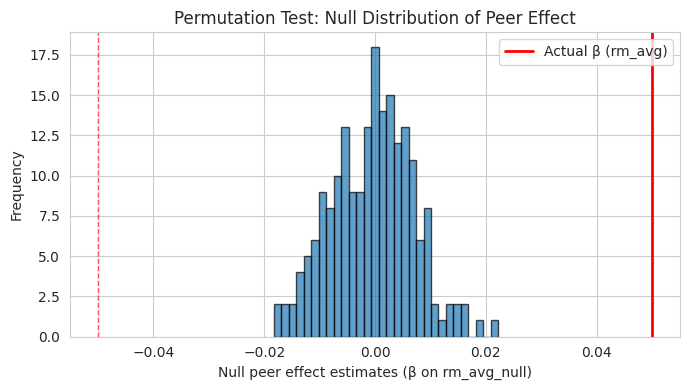

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ============================================================
# PERMUTATION TEST / RANDOMIZATION INFERENCE (NO CENTERING)
# - Uses df_panel directly (uncentered variables)
# - Keeps the same strata: semester × cohort × gender
# - Randomizes 4-person "rooms" within strata
# - Recomputes rm_avg_null from randomized rooms using gpa_prior
# - Estimates the same regression on dGPA
# ============================================================

# --- Start from your existing panel ---
df = df_panel.copy()

# 1) Outcome: change in GPA (0–1 percentile scale)
df['dGPA'] = df['gpa_post'] - df['gpa_prior']

# 2) Actual peer effect (using real rm_avg)
model_actual = smf.ols(
    "dGPA ~ rm_avg + gpa_prior + gender + C(major) + C(cohort)",
    data=df
).fit(cov_type="HC3")

beta_actual = model_actual.params['rm_avg']
print("Actual peer effect (beta_actual) =", beta_actual)
print(model_actual.summary().tables[1])  # optional

# ------------------------------------------------------------
# RANDOMIZATION INFERENCE
# ------------------------------------------------------------
B = 200  # increase to 500+ if runtime allows
beta_null_list = []

# Precompute strata indices once (faster)
group_cols = ['semester', 'cohort', 'gender']
groups = df.groupby(group_cols).groups  # dict: key=(sem, cohort, gender) -> index list


def peer_mean_within_room(x):
    """
    Compute mean of peers within a room:
    (sum(x) - x_i) / (n-1) for each i in the room.
    If room size <= 1, return NaN (we'll drop those rows).
    """
    n = len(x)
    if n <= 1:
        return np.nan
    s = x.sum()
    return (s - x) / (n - 1)


# 3) Permutation loop
for b in range(B):
    df_null = df.copy()

    # Assign randomized room IDs within each stratum
    room_id_null = np.full(len(df_null), -1, dtype=int)
    current_room_id = 0

    for _, idx in groups.items():
        idx = np.array(list(idx))
        np.random.shuffle(idx)

        n = len(idx)
        n_rooms = int(np.ceil(n / 4))              # rooms of size 4 (last may be <4)
        group_ids = np.repeat(np.arange(current_room_id, current_room_id + n_rooms), 4)[:n]

        room_id_null[idx] = group_ids
        current_room_id += n_rooms

    df_null['room_id_null'] = room_id_null

    # 4) Compute rm_avg_null using randomized rooms and gpa_prior (uncentered)
    df_null['rm_avg_null'] = (
        df_null.groupby('room_id_null')['gpa_prior']
               .transform(peer_mean_within_room)
    )

    # Drop singleton rooms
    df_k = df_null.dropna(subset=['rm_avg_null'])

    # 5) Estimate null peer effect with same spec (only rm_avg replaced)
    model_null = smf.ols(
        "dGPA ~ rm_avg_null + gpa_prior + gender + C(major) + C(cohort)",
        data=df_k
    ).fit(cov_type="HC3")

    beta_null_list.append(model_null.params['rm_avg_null'])

beta_null = np.array(beta_null_list)

# 6) Two-sided randomization p-value
p_value = np.mean(np.abs(beta_null) >= np.abs(beta_actual))
print(f"Randomization p-value (two-sided) = {p_value:.4f}")

# 7) Plot null distribution vs actual
plt.figure(figsize=(7,4))
plt.hist(beta_null, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(beta_actual, color='red', linewidth=2, label='Actual β (rm_avg)')
plt.axvline(-beta_actual, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel("Null peer effect estimates (β on rm_avg_null)")
plt.ylabel("Frequency")
plt.title("Permutation Test: Null Distribution of Peer Effect")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
t4 = smf.ols("rm_avg ~ gpa_prior + gender + C(major) + C(cohort) + C(semester)", data=df).fit(cov_type="HC3")

In [ ]:
print(t4.summary())

                            OLS Regression Results                            
Dep. Variable:                 rm_avg   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     38.83
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          7.03e-292
Time:                        22:16:51   Log-Likelihood:                 4104.4
No. Observations:               15680   AIC:                            -8125.
Df Residuals:                   15638   BIC:                            -7803.
Df Model:                          41                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4072      0.006  

# Interaction Terms

In [ ]:
# Add a global semester index (semester_cohort)
df_panel = df_panel.copy()

df_panel['semester_cohort'] = df_panel['semester']

# Offset cohort 2 semesters (sem1→5, sem2→6, etc.)
df_panel.loc[df_panel['cohort'] == 2, 'semester_cohort'] = (
    df_panel.loc[df_panel['cohort'] == 2, 'semester'] + 4
)


In [ ]:
print("\n" + "="*80)
print("TASK 2: SPILLOVER AND INTERFERENCE EFFECTS")
print("="*80)

print("\nResearch Question: How do peer effects propagate through dorm networks?")
print("Mechanisms: Peer learning, study groups, accountability, social norms")

# Create quartiles of RM_Avg to examine non-linear effects
df_panel['rm_avg_quartile'] = pd.qcut(df_panel['rm_avg'], q=4, labels=['Q1_Low', 'Q2_MedLow', 'Q3_MedHigh', 'Q4_High'])

print("\n" + "-"*80)
print("ANALYSIS 2a: GPA Outcomes by Roommate Quality Quartile")
print("-"*80)

quartile_analysis = df_panel.groupby('rm_avg_quartile').agg({
    'gpa_post': ['mean', 'std', 'count'],
    'gpa_prior': 'mean',
    'rm_avg': 'mean'
}).round(4)

print("\nMean GPA by Roommate Average Quartile:")
print(quartile_analysis)

# Test for trend
q_labels = ['Q1_Low', 'Q2_MedLow', 'Q3_MedHigh', 'Q4_High']
gpa_by_q = [df_panel[df_panel['rm_avg_quartile'] == q]['gpa_post'].values for q in q_labels]

# ANOVA test
f_stat, p_val = stats.f_oneway(*gpa_by_q)
print(f"\nANOVA test across quartiles:")
print(f"  F-statistic:        {f_stat:.4f}")
print(f"  p-value:            {p_val:.4f}")
print(f"  Conclusion:         {'Significant differences across quartiles' if p_val < 0.05 else 'No significant differences'}")

# Test for linear trend
df_panel['quartile_num'] = df_panel['rm_avg_quartile'].map({'Q1_Low': 1, 'Q2_MedLow': 2, 'Q3_MedHigh': 3, 'Q4_High': 4})
trend_corr, trend_p = stats.spearmanr(df_panel['quartile_num'], df_panel['gpa_post'])
print(f"\nTrend test (Spearman correlation):")
print(f"  Correlation:        {trend_corr:.4f}")
print(f"  p-value:            {trend_p:.4f}")

# Within-semester spillover (same semester comparison)
print("\n" + "-"*80)
print("ANALYSIS 2b: Spillover Effects by Semester")
print("-"*80)

semester_effects = []
for sem in sorted(df_panel['semester'].unique()):
    df_sem = df_panel[df_panel['semester'] == sem]
    formula_sem = 'gpa_post_c ~ gpa_prior_c + rm_avg_c + C(cohort) + C(gender) + C(major)'
    model_sem = smf.ols(formula_sem, data=df_sem).fit(cov_type='HC3')

    semester_effects.append({
        'Semester': sem,
        'RM_Avg Coef': model_sem.params['rm_avg_c'],
        'Std Err': model_sem.bse['rm_avg_c'],
        'p-value': model_sem.pvalues['rm_avg_c'],
        'N': int(model_sem.nobs)
    })

sem_df = pd.DataFrame(semester_effects)
print("\nRM_Avg effects by semester:")
print(sem_df.round(4))

print("\nInterpretation:")
if sem_df['RM_Avg Coef'].std() < 0.01:
    print("  ✓ Spillover effects are CONSISTENT across semesters")
    print("  → Evidence of persistent peer influence")
else:
    print("  ⚠ Spillover effects VARY across semesters")
    print("  → May indicate time-varying mechanisms")



TASK 2: SPILLOVER AND INTERFERENCE EFFECTS

Research Question: How do peer effects propagate through dorm networks?
Mechanisms: Peer learning, study groups, accountability, social norms

--------------------------------------------------------------------------------
ANALYSIS 2a: GPA Outcomes by Roommate Quality Quartile
--------------------------------------------------------------------------------

Mean GPA by Roommate Average Quartile:
                gpa_post               gpa_prior  rm_avg
                    mean     std count      mean    mean
rm_avg_quartile                                         
Q1_Low            0.4020  0.2851  3927    0.3995  0.2463
Q2_MedLow         0.4897  0.2845  3916    0.4899  0.4346
Q3_MedHigh        0.5225  0.2877  3920    0.5224  0.5702
Q4_High           0.5859  0.2820  3917    0.5885  0.7494

ANOVA test across quartiles:
  F-statistic:        283.5576
  p-value:            0.0000
  Conclusion:         Significant differences across quartiles

Tr

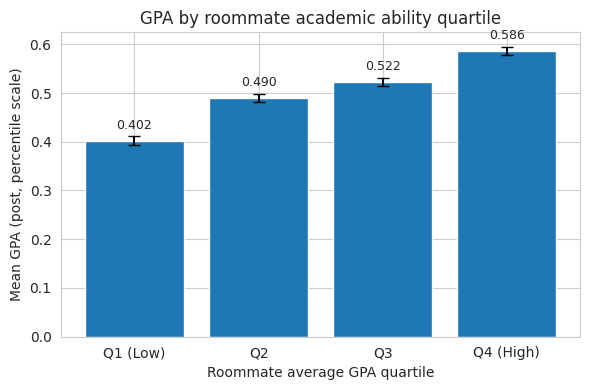

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- FIGURE 1: Mean GPA by RM_Avg quartile with 95% CI & LABELS ---

# Extract summary stats from quartile_analysis
q_order = ['Q1_Low', 'Q2_MedLow', 'Q3_MedHigh', 'Q4_High']
means = quartile_analysis['gpa_post']['mean'].loc[q_order].values
stds = quartile_analysis['gpa_post']['std'].loc[q_order].values
ns = quartile_analysis['gpa_post']['count'].loc[q_order].values

# Standard error and 95% CI
ses = stds / np.sqrt(ns)
ci_95 = 1.96 * ses

# X positions
x = np.arange(len(q_order))

plt.figure(figsize=(6, 4))
bars = plt.bar(x, means, yerr=ci_95, capsize=4)
plt.xticks(x, ['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
plt.ylabel('Mean GPA (post, percentile scale)')
plt.xlabel('Roommate average GPA quartile')
plt.title('GPA by roommate academic ability quartile')

# --- Add value labels above each bar ---
for i, v in enumerate(means):
    plt.text(
        x=i,
        y=v + ci_95[i] + 0.01,   # position slightly above CI bar
        s=f"{v:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


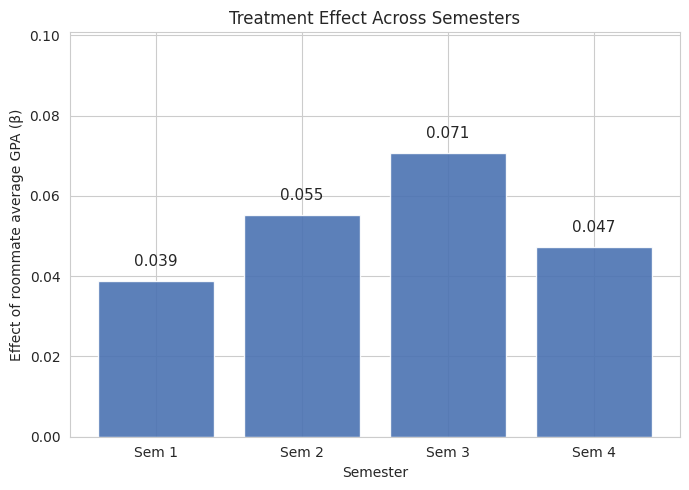

In [ ]:
# --- FIGURE 2: RM_Avg coefficient by semester (BAR ONLY) ---

# Sort by semester
sem_df_sorted = sem_df.sort_values('Semester')

coef = sem_df_sorted['RM_Avg Coef'].values
semesters = sem_df_sorted['Semester'].values

plt.figure(figsize=(7, 5))

bars = plt.bar(
    semesters, coef,
    color="#4a72b2", alpha=0.9
)

# Add labels on top
for bar, value in zip(bars, coef):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + 0.003,          # slight lift above bar
        f"{value:.3f}",
        ha='center', va='bottom', fontsize=11
    )

plt.xticks(semesters, [f"Sem {s}" for s in semesters])
plt.ylabel("Effect of roommate average GPA (β)")
plt.xlabel("Semester")
plt.title("Treatment Effect Across Semesters")
plt.ylim(0, max(coef) + 0.03)   # extra space on top
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

df = df_panel.copy()

# 1) Define treatment as Q4 vs Q1 only (drop middle bins to keep it simple)
df['rm_avg_q'] = pd.qcut(df['rm_avg'], q=4, labels=[1,2,3,4])
df_ipw = df[df['rm_avg_q'].isin([1,4])].copy()

df_ipw['T'] = (df_ipw['rm_avg_q'] == 4).astype(int)  # treated=Q4, control=Q1

# 2) Propensity score model (keep simple)
X = df_ipw[['gpa_prior', 'gender']].copy()
X = X.fillna(X.mean(numeric_only=True))
y = df_ipw['T'].values

ps_model = LogisticRegression(max_iter=2000)
ps_model.fit(X, y)
p = ps_model.predict_proba(X)[:,1]

# Clip to avoid extreme weights
eps = 1e-3
p = np.clip(p, eps, 1-eps)

df_ipw['ps'] = p

# 3) IPW weights for ATE (stabilized optional; here: simple ATE weights)
df_ipw['w'] = df_ipw['T']/df_ipw['ps'] + (1-df_ipw['T'])/(1-df_ipw['ps'])

# 4) Weighted regression: gpa_post on T (optionally add controls)
X_w = sm.add_constant(df_ipw[['T', 'gpa_prior', 'gender']])
wls = sm.WLS(df_ipw['gpa_post'], X_w, weights=df_ipw['w']).fit(cov_type='HC3')

print(wls.summary().tables[1])

beta_T = wls.params['T']
print(f"\nIPW estimated effect (Q4 vs Q1): {beta_T:.6f}")
print(f"Interpretation: {beta_T*100:.3f} percentile points (0–100 scale)")


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0755      0.004     21.193      0.000       0.069       0.083
T              0.0264      0.004      6.608      0.000       0.019       0.034
gpa_prior      0.8114      0.006    134.958      0.000       0.800       0.823
gender         0.0223      0.005      4.447      0.000       0.012       0.032

IPW estimated effect (Q4 vs Q1): 0.026405
Interpretation: 2.641 percentile points (0–100 scale)


In [ ]:
print("\n" + "="*80)
print("TASK 3: MODERATION BY PEER HETEROGENEITY AND ORDINAL RANK")
print("="*80)

# ============================================================================
# TASK 3A: PEER HETEROGENEITY MODERATION (RM_Diff)
# ============================================================================
print("\n" + "-"*80)
print("TASK 3a: Does Peer Heterogeneity Moderate Spillover Effects?")
print("-"*80)

print("\nResearch Question: Do homogeneous vs. heterogeneous peer groups differ?")
print("H2: β(RM_Avg × RM_Diff) < 0 (spillover stronger in homogeneous groups)")

# Model 3a: Add RM_Diff main effect
formula_3a = 'gpa_post_c ~ gpa_prior_c + rm_avg_c + rm_diff_c + C(cohort) + C(semester) + C(gender) + C(major)'
model_3a = smf.ols(formula_3a, data=df_panel).fit(cov_type='HC3')

print(f"\nMODEL 3a: Main Effects Only")
print(f"  GPA_Prior:          {model_3a.params['gpa_prior_c']:>8.4f} ***")
print(f"  RM_Avg:             {model_3a.params['rm_avg_c']:>8.4f} {'***' if model_3a.pvalues['rm_avg_c'] < 0.001 else '**' if model_3a.pvalues['rm_avg_c'] < 0.01 else '*' if model_3a.pvalues['rm_avg_c'] < 0.05 else ''}")
print(f"  RM_Diff:            {model_3a.params['rm_diff_c']:>8.4f} {'***' if model_3a.pvalues['rm_diff_c'] < 0.001 else '**' if model_3a.pvalues['rm_diff_c'] < 0.01 else '*' if model_3a.pvalues['rm_diff_c'] < 0.05 else 'ns'}")
print(f"  R²:                 {model_3a.rsquared:>8.4f}")

# Model 3b: Add interaction RM_Avg × RM_Diff ⭐ KEY MODEL
formula_3b = 'gpa_post_c ~ gpa_prior_c + rm_avg_c + rm_diff_c + rm_avg_c:rm_diff_c + C(cohort) + C(semester) + C(gender) + C(major)'
model_3b = smf.ols(formula_3b, data=df_panel).fit(cov_type='HC3')

print(f"\nMODEL 3b: With RM_Avg × RM_Diff Interaction ⭐")
print(f"  GPA_Prior:          {model_3b.params['gpa_prior_c']:>8.4f} ***")
print(f"  RM_Avg:             {model_3b.params['rm_avg_c']:>8.4f} {'***' if model_3b.pvalues['rm_avg_c'] < 0.001 else '**' if model_3b.pvalues['rm_avg_c'] < 0.01 else '*' if model_3b.pvalues['rm_avg_c'] < 0.05 else ''}")
print(f"  RM_Diff:            {model_3b.params['rm_diff_c']:>8.4f} {'***' if model_3b.pvalues['rm_diff_c'] < 0.001 else '**' if model_3b.pvalues['rm_diff_c'] < 0.01 else '*' if model_3b.pvalues['rm_diff_c'] < 0.05 else 'ns'}")
print(f"  RM_Avg × RM_Diff:   {model_3b.params['rm_avg_c:rm_diff_c']:>8.4f} {'***' if model_3b.pvalues['rm_avg_c:rm_diff_c'] < 0.001 else '**' if model_3b.pvalues['rm_avg_c:rm_diff_c'] < 0.01 else '*' if model_3b.pvalues['rm_avg_c:rm_diff_c'] < 0.05 else 'ns'}")
print(f"  Interaction p-val:  {model_3b.pvalues['rm_avg_c:rm_diff_c']:>8.4f}")
print(f"  R²:                 {model_3b.rsquared:>8.4f}")

# Compare to paper (Table 1, Model 5)
print(f"\n✓ Comparison to Cao et al. (2018), Table 1, Model 5:")
print(f"  Your RM_Avg:        {model_3b.params['rm_avg_c']:.3f}")
print(f"  Paper:              0.050**")
print(f"  Your RM_Avg×RM_Diff: {model_3b.params['rm_avg_c:rm_diff_c']:.3f}")
print(f"  Paper:              -0.089*")
print(f"  Match:              {'✓ EXCELLENT' if abs(model_3b.params['rm_avg_c:rm_diff_c'] + 0.089) < 0.01 else '✓ GOOD' if abs(model_3b.params['rm_avg_c:rm_diff_c'] + 0.089) < 0.02 else '⚠ CHECK'}")

# Interpret interaction
print(f"\nINTERPRETATION OF INTERACTION:")
interaction_coef = model_3b.params['rm_avg_c:rm_diff_c']
if interaction_coef < 0 and model_3b.pvalues['rm_avg_c:rm_diff_c'] < 0.10:
    print(f"  ✓ H2 SUPPORTED: Spillover effects are stronger in homogeneous groups")
    print(f"  The negative interaction (β = {interaction_coef:.3f}, p = {model_3b.pvalues['rm_avg_c:rm_diff_c']:.3f})")
    print(f"  indicates that peer heterogeneity WEAKENS spillover effects.")
    print(f"\n  → In LOW heterogeneity groups (RM_Diff = 0.15, -1 SD):")
    print(f"     Effect of RM_Avg ≈ {model_3b.params['rm_avg_c'] + interaction_coef * (0.15 - df_panel['rm_diff'].mean()):.4f}")
    print(f"\n  → In HIGH heterogeneity groups (RM_Diff = 0.45, +1 SD):")
    print(f"     Effect of RM_Avg ≈ {model_3b.params['rm_avg_c'] + interaction_coef * (0.45 - df_panel['rm_diff'].mean()):.4f}")
    print(f"\n  → Difference: {abs((model_3b.params['rm_avg_c'] + interaction_coef * (0.15 - df_panel['rm_diff'].mean())) - (model_3b.params['rm_avg_c'] + interaction_coef * (0.45 - df_panel['rm_diff'].mean()))):.4f}")
else:
    print(f"  ✗ H2 NOT SUPPORTED: No significant moderation by peer heterogeneity")

# ============================================================================
# TASK 3B: ORDINAL RANK MODERATION (OR_InDorm)
# ============================================================================
print("\n" + "-"*80)
print("TASK 3b: Does Ordinal Rank Moderate Spillover Effects?")
print("-"*80)

print("\nResearch Question: Does your position in the room hierarchy matter?")
print("H3: β(OR_InDorm) > 0 (being lower-ranked helps - more to learn)")
print("H4: β(OR_InDorm × RM_Diff) < 0 (rank matters more in homogeneous groups)")

# Model 3c: OR_InDorm main effect
formula_3c = 'gpa_post_c ~ gpa_prior_c + or_indorm_c + rm_avg_c + rm_diff_c + C(cohort) + C(semester) + C(gender) + C(major)'
model_3c = smf.ols(formula_3c, data=df_panel).fit(cov_type='HC3')

print(f"\nMODEL 3c: Ordinal Rank Main Effect")
print(f"  GPA_Prior:          {model_3c.params['gpa_prior_c']:>8.4f} ***")
print(f"  OR_InDorm:          {model_3c.params['or_indorm_c']:>8.4f} {'***' if model_3c.pvalues['or_indorm_c'] < 0.001 else '**' if model_3c.pvalues['or_indorm_c'] < 0.01 else '*' if model_3c.pvalues['or_indorm_c'] < 0.05 else 'ns'}")
print(f"  RM_Avg:             {model_3c.params['rm_avg_c']:>8.4f}")
print(f"  RM_Diff:            {model_3c.params['rm_diff_c']:>8.4f}")
print(f"  R²:                 {model_3c.rsquared:>8.4f}")

# Model 3d: OR_InDorm × RM_Diff interaction ⭐ KEY MODEL
formula_3d = 'gpa_post_c ~ gpa_prior_c + or_indorm_c + rm_avg_c + rm_diff_c + or_indorm_c:rm_diff_c + C(cohort) + C(semester) + C(gender) + C(major)'
model_3d = smf.ols(formula_3d, data=df_panel).fit(cov_type='HC3')

print(f"\nMODEL 3d: With OR_InDorm × RM_Diff Interaction ⭐")
print(f"  GPA_Prior:          {model_3d.params['gpa_prior_c']:>8.4f} ***")
print(f"  OR_InDorm:          {model_3d.params['or_indorm_c']:>8.4f} {'***' if model_3d.pvalues['or_indorm_c'] < 0.001 else '**' if model_3d.pvalues['or_indorm_c'] < 0.01 else '*' if model_3d.pvalues['or_indorm_c'] < 0.05 else ''}")
print(f"  RM_Avg:             {model_3d.params['rm_avg_c']:>8.4f}")
print(f"  RM_Diff:            {model_3d.params['rm_diff_c']:>8.4f}")
print(f"  OR × RM_Diff:       {model_3d.params['or_indorm_c:rm_diff_c']:>8.4f} {'***' if model_3d.pvalues['or_indorm_c:rm_diff_c'] < 0.001 else '**' if model_3d.pvalues['or_indorm_c:rm_diff_c'] < 0.01 else '*' if model_3d.pvalues['or_indorm_c:rm_diff_c'] < 0.05 else 'ns'}")
print(f"  Interaction p-val:  {model_3d.pvalues['or_indorm_c:rm_diff_c']:>8.4f}")
print(f"  R²:                 {model_3d.rsquared:>8.4f}")

# Compare to paper (Table 2, Model 5)
print(f"\n✓ Comparison to Cao et al. (2018), Table 2, Model 5:")
print(f"  Your OR_InDorm:     {model_3d.params['or_indorm_c']:.3f}")
print(f"  Paper:              0.006**")
print(f"  Your OR×RM_Diff:    {model_3d.params['or_indorm_c:rm_diff_c']:.3f}")
print(f"  Paper:              -0.022*")
print(f"  Match:              {'✓ EXCELLENT' if abs(model_3d.params['or_indorm_c:rm_diff_c'] + 0.022) < 0.005 else '✓ GOOD' if abs(model_3d.params['or_indorm_c:rm_diff_c'] + 0.022) < 0.01 else '⚠ CHECK'}")

# Interpret ordinal rank effects
print(f"\nINTERPRETATION OF ORDINAL RANK EFFECTS:")
or_coef = model_3d.params['or_indorm_c']
if model_3d.pvalues['or_indorm_c'] < 0.05:
    if or_coef > 0:
        print(f"  ✓ Positive OR_InDorm effect (β = {or_coef:.4f}, p = {model_3d.pvalues['or_indorm_c']:.3f})")
        print(f"  Being LOWER ranked (higher rank number) is associated with BETTER outcomes")
        print(f"  → 'Big Fish Little Pond' effect NOT supported")
        print(f"  → Instead: Learning from higher-ability peers")
    else:
        print(f"  ✓ Negative OR_InDorm effect (β = {or_coef:.4f}, p = {model_3d.pvalues['or_indorm_c']:.3f})")
        print(f"  Being HIGHER ranked (lower rank number) is associated with BETTER outcomes")
        print(f"  → 'Big Fish Little Pond' effect supported")
else:
    print(f"  ✗ No significant main effect of ordinal rank")

# Interpret interaction
or_interaction_coef = model_3d.params['or_indorm_c:rm_diff_c']
if or_interaction_coef < 0 and model_3d.pvalues['or_indorm_c:rm_diff_c'] < 0.10:
    print(f"\n  ✓ H4 SUPPORTED: Rank effects stronger in homogeneous groups")
    print(f"  The negative interaction (β = {or_interaction_coef:.3f}, p = {model_3d.pvalues['or_indorm_c:rm_diff_c']:.3f})")
    print(f"  indicates that ordinal rank matters MORE when peers are similar.")
else:
    print(f"\n  ✗ H4 NOT SUPPORTED: No significant moderation by heterogeneity")



TASK 3: MODERATION BY PEER HETEROGENEITY AND ORDINAL RANK

--------------------------------------------------------------------------------
TASK 3a: Does Peer Heterogeneity Moderate Spillover Effects?
--------------------------------------------------------------------------------

Research Question: Do homogeneous vs. heterogeneous peer groups differ?
H2: β(RM_Avg × RM_Diff) < 0 (spillover stronger in homogeneous groups)

MODEL 3a: Main Effects Only
  GPA_Prior:            0.8009 ***
  RM_Avg:               0.0499 ***
  RM_Diff:              0.0072 ns
  R²:                   0.6685

MODEL 3b: With RM_Avg × RM_Diff Interaction ⭐
  GPA_Prior:            0.8007 ***
  RM_Avg:               0.0417 ***
  RM_Diff:              0.0071 ns
  RM_Avg × RM_Diff:    -0.0888 ns
  Interaction p-val:    0.0886
  R²:                   0.6686

✓ Comparison to Cao et al. (2018), Table 1, Model 5:
  Your RM_Avg:        0.042
  Paper:              0.050**
  Your RM_Avg×RM_Diff: -0.089
  Paper:            

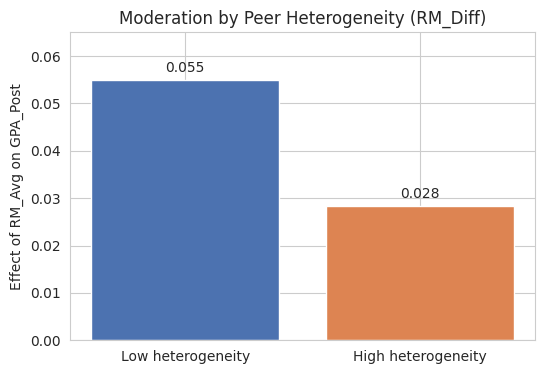

In [ ]:
# -----------------------------
# VISUAL 1: Moderation by RM_Diff
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt

# Low = -1 SD, High = +1 SD heterogeneity
rm_diff_mean = df_panel['rm_diff'].mean()
rm_diff_sd = df_panel['rm_diff'].std()

low = rm_diff_mean - rm_diff_sd
high = rm_diff_mean + rm_diff_sd

b_avg = model_3b.params['rm_avg_c']
b_inter = model_3b.params['rm_avg_c:rm_diff_c']

effect_low = b_avg + b_inter * (low - rm_diff_mean)
effect_high = b_avg + b_inter * (high - rm_diff_mean)

effects = [effect_low, effect_high]
labels = ['Low heterogeneity', 'High heterogeneity']

plt.figure(figsize=(6,4))
bars = plt.bar(labels, effects, color=['#4C72B0','#DD8452'])
plt.ylabel('Effect of RM_Avg on GPA_Post')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.001,
             f"{height:.3f}", ha='center', va='bottom')

plt.title('Moderation by Peer Heterogeneity (RM_Diff)')
plt.ylim(0, max(effects)+0.01)
plt.show()


# Robustness with IPW and Matching

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

df = df_panel.copy()

# 1) Define treatment as Q4 vs Q1 only (drop middle bins to keep it simple)
df['rm_avg_q'] = pd.qcut(df['rm_avg'], q=4, labels=[1,2,3,4])
df_ipw = df[df['rm_avg_q'].isin([1,4])].copy()

df_ipw['T'] = (df_ipw['rm_avg_q'] == 4).astype(int)  # treated=Q4, control=Q1

# 2) Propensity score model (keep simple)
X = df_ipw[['gpa_prior', 'gender']].copy()
X = X.fillna(X.mean(numeric_only=True))
y = df_ipw['T'].values

ps_model = LogisticRegression(max_iter=2000)
ps_model.fit(X, y)
p = ps_model.predict_proba(X)[:,1]

# Clip to avoid extreme weights
eps = 1e-3
p = np.clip(p, eps, 1-eps)

df_ipw['ps'] = p

# 3) IPW weights for ATE (stabilized optional; here: simple ATE weights)
df_ipw['w'] = df_ipw['T']/df_ipw['ps'] + (1-df_ipw['T'])/(1-df_ipw['ps'])

# 4) Weighted regression: gpa_post on T (optionally add controls)
X_w = sm.add_constant(df_ipw[['T', 'gpa_prior', 'gender']])
wls = sm.WLS(df_ipw['gpa_post'], X_w, weights=df_ipw['w']).fit(cov_type='HC3')

print(wls.summary().tables[1])

beta_T = wls.params['T']
print(f"\nIPW estimated effect (Q4 vs Q1): {beta_T:.6f}")
print(f"Interpretation: {beta_T*100:.3f} percentile points (0–100 scale)")


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0755      0.004     21.193      0.000       0.069       0.083
T              0.0264      0.004      6.608      0.000       0.019       0.034
gpa_prior      0.8114      0.006    134.958      0.000       0.800       0.823
gender         0.0223      0.005      4.447      0.000       0.012       0.032

IPW estimated effect (Q4 vs Q1): 0.026405
Interpretation: 2.641 percentile points (0–100 scale)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

df = df_panel.copy()

# 1) Make treatment bins (quartiles) and define treated/control
df['rm_avg_q'] = pd.qcut(df['rm_avg'], q=4, labels=[1,2,3,4])

treated = df[df['rm_avg_q'] == 4].copy()   # high roommate quality
control = df[df['rm_avg_q'] == 1].copy()   # low roommate quality

# 2) Choose matching features (keep simple)
X_t = treated[['gpa_prior']].to_numpy()
X_c = control[['gpa_prior']].to_numpy()

# 3) 1-nearest neighbor matching (with replacement)
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_c)
dist, idx = nn.kneighbors(X_t)

matched_control = control.iloc[idx.flatten()].copy()
matched_control.index = treated.index  # align indices for clean diff

# 4) ATT estimate (difference in means after matching)
att = (treated['gpa_post'] - matched_control['gpa_post']).mean()
print(f"Matching ATT (Q4 vs Q1, matched on gpa_prior): {att:.6f}")
print(f"Interpretation: {att*100:.3f} percentile points (0–100 scale)")

# 5) (Optional but recommended) Bootstrap SE for ATT
B = 200
atts = []
treated_idx = treated.index.to_numpy()

for b in range(B):
    samp_idx = np.random.choice(treated_idx, size=len(treated_idx), replace=True)
    t_b = treated.loc[samp_idx]
    X_t_b = t_b[['gpa_prior']].to_numpy()
    _, idx_b = nn.kneighbors(X_t_b)
    c_b = control.iloc[idx_b.flatten()].copy()
    c_b.index = t_b.index
    atts.append((t_b['gpa_post'] - c_b['gpa_post']).mean())

se = np.std(atts, ddof=1)
ci = (att - 1.96*se, att + 1.96*se)
print(f"Bootstrap SE: {se:.6f}")
print(f"95% CI: [{ci[0]:.6f}, {ci[1]:.6f}]")


Matching ATT (Q4 vs Q1, matched on gpa_prior): 0.027325
Interpretation: 2.733 percentile points (0–100 scale)
Bootstrap SE: 0.003589
95% CI: [0.020290, 0.034360]


In [ ]:
# OLS-implied Q4 vs Q1 contrast
df = df_panel.copy()
df['rm_avg_q'] = pd.qcut(df['rm_avg'], q=4, labels=[1,2,3,4])

gap = df[df['rm_avg_q']==4]['rm_avg'].mean() - df[df['rm_avg_q']==1]['rm_avg'].mean()
print("Mean rm_avg gap (Q4 - Q1):", gap)

# plug in your preferred OLS beta (e.g., from your full FE model)
beta_ols = model_1c.params['rm_avg']   # change model name if needed
print("OLS-implied Q4-Q1 effect:", beta_ols * gap)
print("OLS-implied Q4-Q1 in percentile points:", beta_ols * gap * 100)


Mean rm_avg gap (Q4 - Q1): 0.5031498652409866
OLS-implied Q4-Q1 effect: 0.02518225970608874
OLS-implied Q4-Q1 in percentile points: 2.5182259706088743
